# Periodic Electronic Structure: ProblemInstance and Encoding

<font size="3">

<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.
<hr><hr>
</font>

In [1]:
from pyLIQTR.ProblemInstances.getInstance   import *
from pyLIQTR.BlockEncodings.getEncoding     import *
from pyLIQTR.utils.circuit_decomposition    import circuit_decompose_multi
from pyLIQTR.utils.resource_analysis        import estimate_resources
from pyLIQTR.qubitization.qubitized_gates   import QubitizedWalkOperator
from pyLIQTR.utils.printing               import openqasm

import cirq
import cirq_ft as cft
from cirq.contrib.svg     import  SVGCircuit

##### <u>References:</u>
[1] [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662)

# Overview

This notebook walks through how to encode and perform resource analysis for periodic electronic structure Hamiltonians generated using `PEST`. See [problem_setup](problem_setup.ipynb) to learn how these types of Hamiltonians can be generated.

# Problem set up: generate a ProblemInstance

`PEST` generates periodic electronic structure Hamiltonians and stores the information in two files:
- '*.grid.hdf5': contains the basis grid
- '*.ham.hdf5': contains the Hamiltonian coefficients

To encode these types of Hamiltonians in `pyLIQTR`, we first select the 'ElectronicStructure' instance and pass the two filenames as inputs:

In [2]:
example_ham_filename = "example.ham.hdf5"
example_grid_filename = "example.grid.hdf5"
example_hamiltonian = getInstance('ElectronicStructure',filenameH=example_ham_filename,filenameG=example_grid_filename)
print(example_hamiltonian)

ElectronicStructure
	Hamiltonian filename:example.ham.hdf5	Grid filename:example.grid.hdf5
	N:27	M_vals:[3 3 3]


Here, M_vals corresponds to the number of real-space grid points along each dimension and N is the total number of basis functions (multiply by 2 for spin-orbitals). This ElectronicStructure instance can be passed directly to a `pyLIQTR` BlockEncoding.

# Encode the Hamiltonian

To encode the Hamiltonian using `pyLIQTR`, we pass the ElectronicStructure instance and select an encoding from the currently supported algorithms. A good choice for encoding these types of Hamiltonians is the `LinearT` block encoding, which is based on the algorithm in [[1]](https://arxiv.org/pdf/1805.03662.pdf) Section IV. This algorithm encodes Hamiltonians of the form
$$
H = \sum_{p,q,\sigma} T(p-q) a^\dagger_{p,\sigma}a_{q,\sigma} + \sum_{p,\sigma} U(p) n_{p,\sigma} + \sum_{(p,\alpha)\neq(q,\beta)} V(p-q)n_{p,\alpha}n_{q,\beta}
$$

where $a^\dagger_{p,\sigma}$ and $a_{p,\sigma}$ are fermionic creation and annihilation operators on spatial orbital $p$ with spin $\sigma \in \{\uparrow,\downarrow\}$, and $n_{p,\sigma} = a^\dagger_{p,\sigma}a_{p,\sigma}$ is the number operator.

The `pyLIQTR` LinearT encoding implementation uses two parameters: \
`energy_error` - the desired accuracy of the estimated energy spectra in the same units as the Hamiltonian coefficients (Hartree)\
`control_val`  - the value the Select oracle is controlled on

The encoding will use the `energy_error` input to determine `approx_error`, which is the precision to which the Hamiltonian coefficients will be prepared. This is based on the conditions indicated in [[1]](https://arxiv.org/pdf/1805.03662.pdf) Eqs. (35) and (36). Alternatively, the user can pass the desired value of approx_error as a keyword argument and omit the energy_error value.

In [3]:
energy_error = .5
example_hamiltonian_encoding = getEncoding(VALID_ENCODINGS.LinearT, instance=example_hamiltonian, energy_error=energy_error, control_val=1)
print(f'Coefficient precision is {example_hamiltonian_encoding.approx_error:1.1e} based on error in energy spectra equal to {energy_error:1.1e}')
# Alternative: pass approx_error explicitly (uncomment below to execute)
# example_hamiltonian_encoding = getEncoding(VALID_ENCODINGS.LinearT, instance = example_hamiltonian, approx_error=1e-3, control_val=1)

Coefficient precision is 3.0e-06 based on error in energy spectra equal to 5.0e-01


The encoding provides access to the registers it acts on as well as the encoding circuit as seen below.

In [4]:
registers = cft.infra.get_named_qubits(example_hamiltonian_encoding.signature)
print(registers)

{'control': array([cirq.NamedQubit('control')], dtype=object), 'theta': array([cirq.NamedQubit('theta')], dtype=object), 'U': array([cirq.NamedQubit('U')], dtype=object), 'V': array([cirq.NamedQubit('V')], dtype=object), 'p': array([cirq.NamedQubit('p0'), cirq.NamedQubit('p1'),
       cirq.NamedQubit('p2'), cirq.NamedQubit('p3'),
       cirq.NamedQubit('p4'), cirq.NamedQubit('p5')], dtype=object), 'a': array([cirq.NamedQubit('a')], dtype=object), 'q': array([cirq.NamedQubit('q0'), cirq.NamedQubit('q1'),
       cirq.NamedQubit('q2'), cirq.NamedQubit('q3'),
       cirq.NamedQubit('q4'), cirq.NamedQubit('q5')], dtype=object), 'b': array([cirq.NamedQubit('b')], dtype=object), 'target': array([cirq.NamedQubit('target0'), cirq.NamedQubit('target1'),
       cirq.NamedQubit('target2'), cirq.NamedQubit('target3'),
       cirq.NamedQubit('target4'), cirq.NamedQubit('target5'),
       cirq.NamedQubit('target6'), cirq.NamedQubit('target7'),
       cirq.NamedQubit('target8'), cirq.NamedQubit('targe

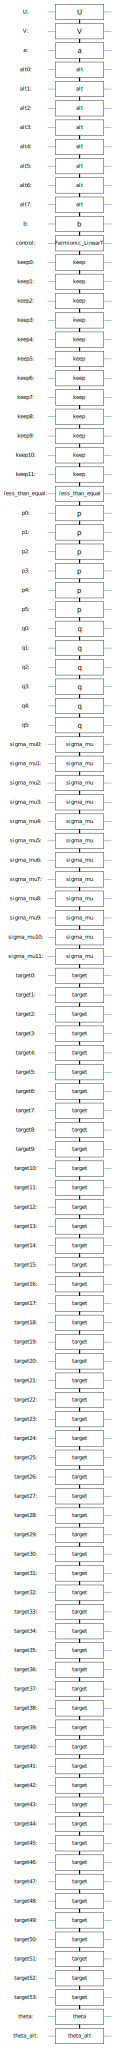

In [5]:
encoding_circuit = example_hamiltonian_encoding.circuit
SVGCircuit(encoding_circuit)

---
#### LIQTR Like 👍 : Circuit Decomposition
---
`cirq` / `cirq-ft` provide the ability to decompose circuits/operators into their constituent parts (ie, a QSVT sequence is a cosine and then sine sequence). Different circuits will have different levels of decomposition, since they are composed of different operators. 

We generally think of a "level 0" decomposition as being the original circuit, a "level N-1" decomposition being a circuit level that includes non-clifford+T gates, and a "level N" decomposition as the level that consists of just the valid gate set for the architcture (ie clifford+T).

The following lines show some of the supported levels of decompositions:

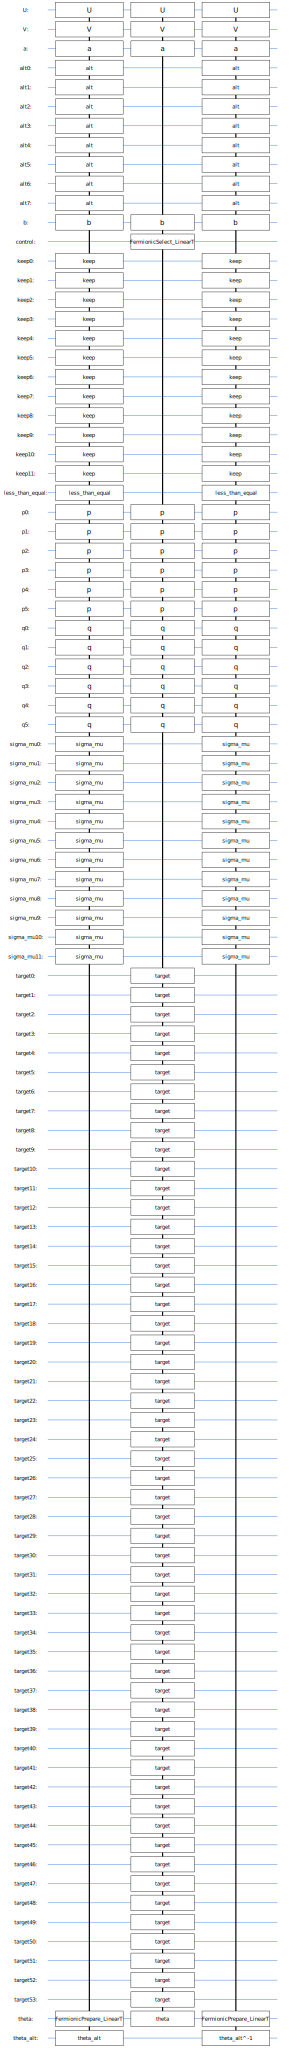

In [6]:
SVGCircuit(circuit_decompose_multi(encoding_circuit,1))

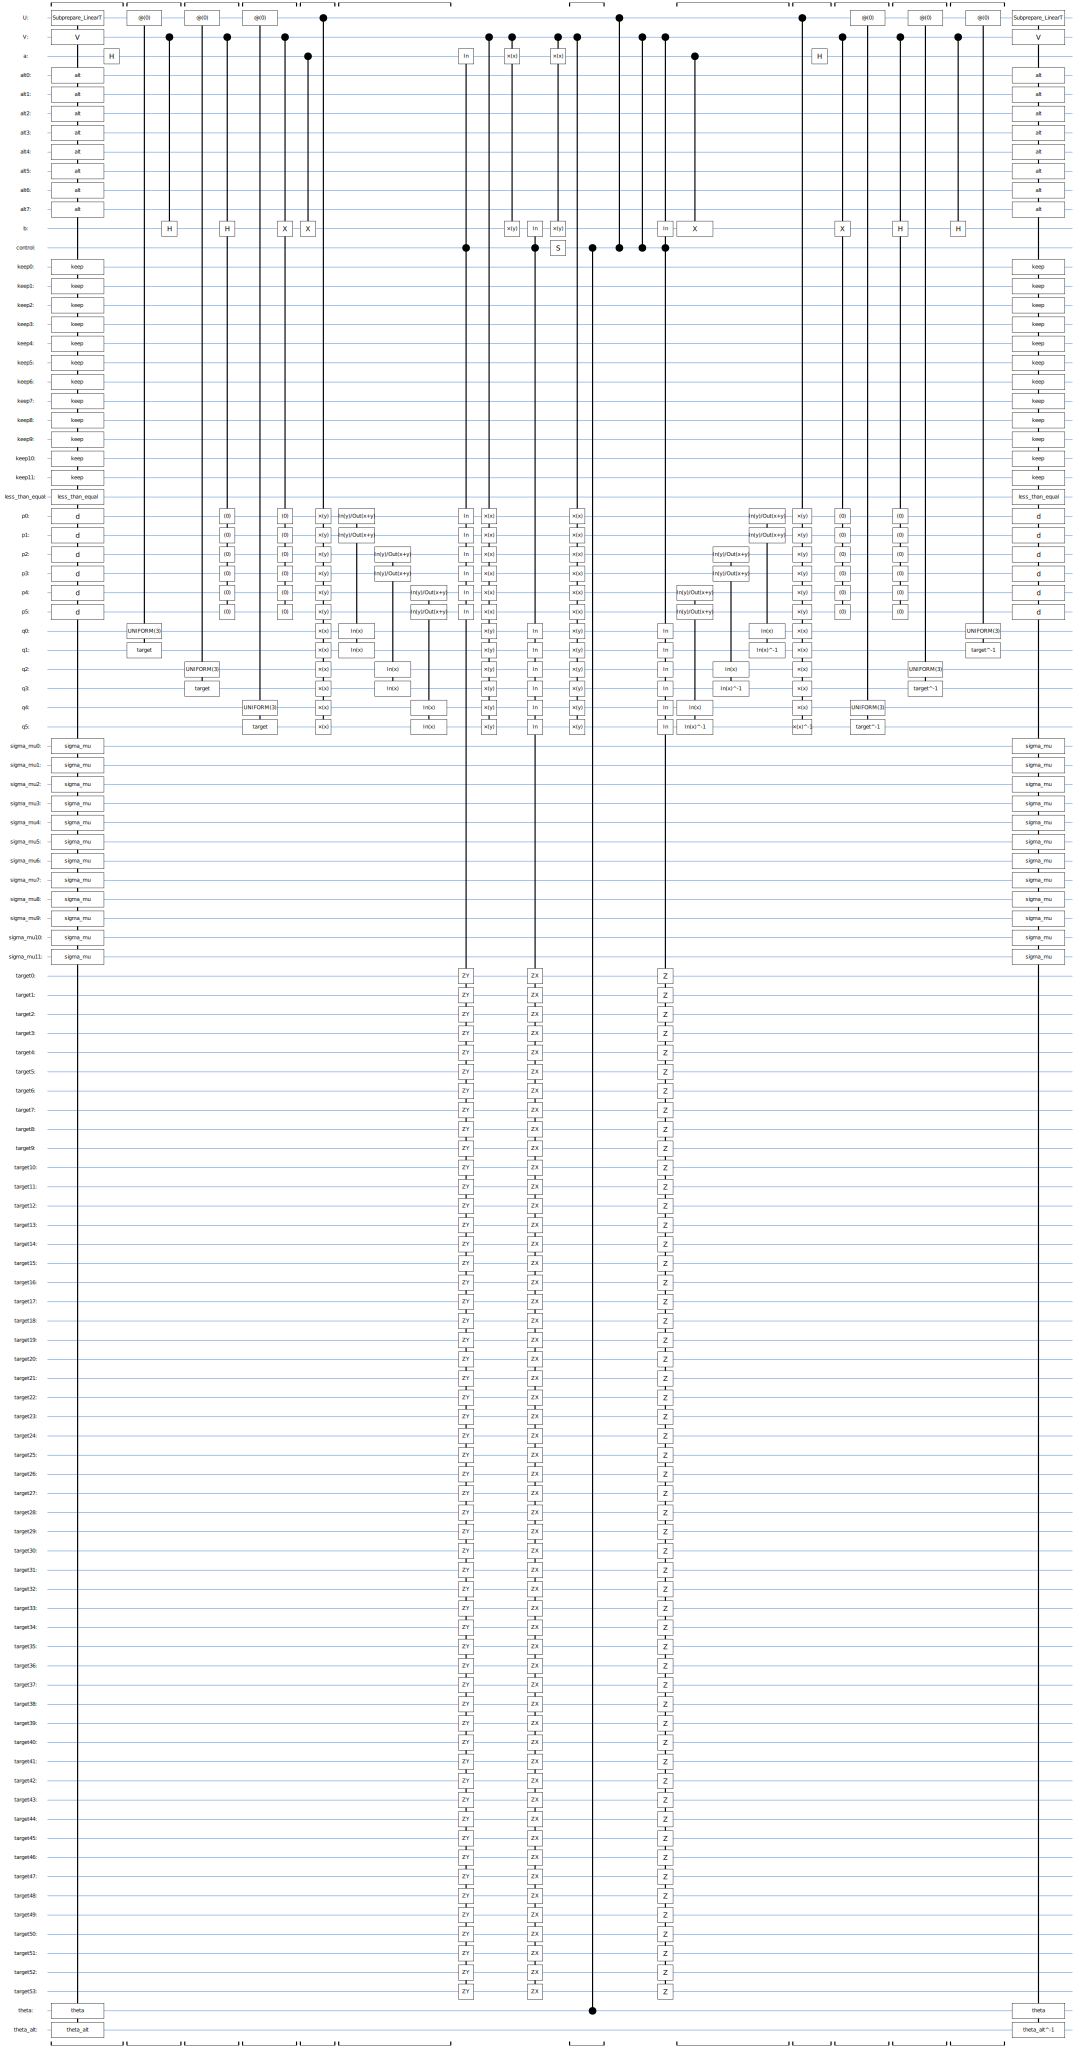

In [7]:
SVGCircuit(circuit_decompose_multi(encoding_circuit,2))

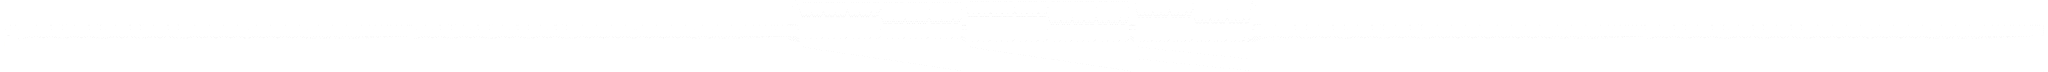

In [8]:
SVGCircuit(circuit_decompose_multi(encoding_circuit,3))

---

## Encoding details

The algorithm encodes Hamiltonians of this form using the `FermionicSelect_LinearT` and `FermionicPrepare_LinearT` classes. 

### The SELECT oracle

The SELECT oracle performs the operation
$$
\text{SELECT}|\theta,U,V,p,\alpha,q,\beta\rangle|\psi\rangle = (-1)^\theta|\theta,U,V,p,\alpha,q,\beta\rangle \otimes 
\begin{cases}
     Z_{p,\alpha}|\psi\rangle  & U ∧ ¬V ∧ ((p,\alpha)=(q,\beta)) \\
     Z_{p,\alpha}Z_{q,\beta}|\psi\rangle  &     ¬U ∧ V ∧ ((p,\alpha)\neq(q,\beta)) \\
     X_{p,\alpha}Z X_{q,\alpha}|\psi\rangle   &  ¬U ∧ ¬V ∧ (p\lt q) ∧ (\alpha=\beta) \\
     Y_{q,\alpha}Z Y_{p,\alpha}|\psi\rangle   &  ¬U ∧ ¬V ∧ (p\gt q) ∧ (\alpha=\beta) \\
     \text{undefined} & \text{otherwise}
\end{cases}
$$
where $\alpha$ and $\beta$ are used to specify the spins, which together with $p$ and $q$ specify the spin-orbital, $U$ and $V$ are used to specify which Pauli operator is applied, and $\theta$ encodes the phase of the coefficient.

The class `FermionicSelect_LinearT` uses two inputs to implement this operation:
- `M_vals`: An array where each entry corresponds to the number of real space grid points along the associated spatial dimension.
- `control_val`: An integer which determines if the oracle is controlled or not.

### The PREPARE oracle

The PREPARE oracle performs the operation
$$
\text{PREPARE} |0\rangle^{\otimes 3+2\log_2N_{so}} \rightarrow \left(\sum_{p,\sigma} \tilde{U}(p) |\theta_p\rangle |1\rangle_U |0\rangle_V |p, \sigma, p, \sigma\rangle  
        + \sum_{p\neq q, \sigma} \tilde{T}(p-q) |\theta_{p-q}^{(0)}\rangle |0\rangle_U |0\rangle_V |p, \sigma, q, \sigma\rangle \right. \\ 
        +\left. \sum_{(p,\alpha)\neq(q,\beta)} \tilde{V}(p-q) |\theta_{p-q}^{(1)}\rangle |0\rangle_U |1\rangle_V  |p,\alpha,q,\beta\rangle\right) |temp\rangle
$$
where $|temp\rangle$ represents the state of ancilla qubits used for the preparation which are not used for the selection. Due to entanglement, these qubits are not perfectly uncomputed by a ($\small\text{PREPARE}^{-1} \cdot \text{SELECT} \cdot \text{PREPARE}$) series and so must be kept and passed to later iterations. The coefficients are defined as 
\begin{align*}
&\tilde{U}(p) = \sqrt{\frac{\left|T(0) + U(p) +\sum_q V(p-q)\right|}{2\lambda}}, &\tilde{T}(p) = \sqrt{\frac{\left|T(p)\right|}{\lambda}}, &&\tilde{V}(p) = \sqrt{\frac{\left|V(p)\right|}{4\lambda}}\\
& \theta_p = \frac{1-\text{sign}\left(-T(0)-U(p)-\sum_q V(p-q)\right)}{2}, &  \theta_p^{(0)} = \frac{1-\text{sign}\left(T(p)\right)}{2}, && \theta_p^{(1)} = \frac{1-\text{sign}\left(V(p)\right)}{2}
\end{align*}
with $ \lambda = \sum_{pq} |T(p-q)| + \sum_p |U(p)| + \sum_{p\neq q} |V(p-q)| $.

The class `FermionicPrepare_LinearT` uses 5 inputs to implement this operation:
- `T_array`: The (XZX + YZY) operator coefficients multiplied by 2, equivalent to $\lambda\tilde{T}^2$. Formatted such that T_array[p] = $(\theta_p^{(0)},\lambda\tilde{T}(p)^2)$ for $p \in [0,N_{so}]$.
- `U_array`: The (Z) operator coefficients, equivalent to $\lambda\tilde{U}^2$. Formatted such that U_array[p] = $(\theta_p,\lambda\tilde{U}(p)^2)$ for $p \in [0,N_{so}]$.
- `V_array`: The (ZZ) operator coefficients, equivalent to $\lambda\tilde{V}^2$. Formatted such that V_array[p] = $(\theta_p^{(1)},\lambda\tilde{V}(p)^2)$ for $p \in [0,N_{so}]$.
- `M_vals`: An array where each entry corresponds to the number of real space grid points along the associated spatial dimension.
- `approx_error`: The desired accuracy to represent each coefficient.

---
#### LIQTR Like 👍 : Resource Analysis
---
Resource analysis of `cirq` circuits can be done by using the `pyLIQTR.utils.resource_analysis.estimate_resources` function, which will provide T, qubit, and Clifford counts for most circuits!

Note that our estimate for T-count is done via experimentally derived statistical distribution for the Clifford count of rotations at a given precision. This can be passed explicitly using the `rotation_gate_precision` (default 1e-10) keyword argument, or can be implicitly calculated by passing the `circuit_precision`. If no precision argument is provided, the default value will be used.

In [9]:
num_iterations = 1000 #number of times encoding block is repeated in circuit of interest
circuit_precision = energy_error/num_iterations
resource_estimate = estimate_resources(encoding_circuit,circuit_precision=circuit_precision)
print(resource_estimate)

{'LogicalQubits': 106, 'T': 94720, 'Clifford': 198616}


---
#### LIQTR Like 👍 : Export of circuits to OpenQASM
---
Export of circuits can be done using a provided `pyLIQTR` utility (`pyLIQTR.utils.printing.openqasm`) that wraps `cirq`'s native openQASM export. This is introduced since some new cirq-ft operators do not yet have a decomposition in terms of gates defined, or `cirq` has begun to use features (mid-circuit measurement, classical control, etc) not supported by OpenQASM2.

This utility fully decomposes circuits to either include rotation gates (`rotation_allowed=True`) or not (`rotation_allowed=False`). 

In the latter case, we make use a of a Clifford+T representation outlined in https://arxiv.org/pdf/0806.3834.pdf (and further discussed in https://arxiv.org/pdf/1312.6584.pdf and http://www.cs.umd.edu/~amchilds/qa/qa.pdf, as potentially easier to digest forms).

When `rotation_allowed=False`, we introduce the "rx_d/ry_d/rz_d gate", followed by a line of the form:
```
// (leading_T, gate_sequence, sequence_length, clifford_part)
```
* `leading_T` : A bool indicating whether or not there is a `T` gate at the start of the sequence
* `gate_sequence`: An int whose binary representation encodes a sequence of `H`, `S`, and `T` gates
* `sequence_length`: The number of `T` gates in the sequence (note if `leading_T` is true, the total number of gates is `sequence_length+1`)
* `clifford_part`: A List[str] of clifford gates that come at the end of the H,S,T sequence.

Note that when `rotation_allowed=False`, you may also want to specify a level of precision by passing `gate_precision` or `circuit_precision` to `pyLIQTR.utils.printing.openqasm`

In [10]:
greedy_mm = cirq.GreedyQubitManager(prefix="_ancilla", maximize_reuse=False)
context = cirq.DecompositionContext(greedy_mm)
for ctr,line in enumerate(openqasm(encoding_circuit,rotation_allowed=True,context=context)):
    print(line)
    if ctr > 100:
        break

// Generated from Cirq, Openfermion, and MIT LL

OPENQASM 2.0;
include "qelib1.inc";

// Qubits: [U, V, _ancilla_0, _ancilla_1, _ancilla_2, _ancilla_3, _ancilla_4, _ancilla_5, _ancilla_6, _ancilla_7, _ancilla_8, _ancilla_9, _ancilla_10, _ancilla_11, _ancilla_12, _ancilla_13, _ancilla_14, _ancilla_15, _ancilla_16, _ancilla_17, _ancilla_18, _ancilla_19, _ancilla_20, _ancilla_21, _ancilla_22, _ancilla_23, _ancilla_24, _ancilla_25, _ancilla_26, _ancilla_27, _ancilla_28, _ancilla_29, _ancilla_30, _ancilla_31, _ancilla_32, _ancilla_33, _ancilla_34, _ancilla_35, _ancilla_36, _ancilla_37, _ancilla_38, _ancilla_39, _ancilla_40, _ancilla_41, _ancilla_42, _ancilla_43, _ancilla_44, _ancilla_45, _ancilla_46, _ancilla_47, _ancilla_48, _ancilla_49, _ancilla_50, _ancilla_51, _ancilla_52, _ancilla_53, _ancilla_54, _ancilla_55, _ancilla_56, _ancilla_57, _ancilla_58, _ancilla_59, _ancilla_60, _ancilla_61, _ancilla_62, _ancilla_63, _ancilla_64, _ancilla_65, _ancilla_66, _ancilla_67, _ancilla_68, _ancilla_

---